The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.0-alpha1.post0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 93 kB 1.0 MB/s 
     |████████████████████████████████| 120 kB 16.0 MB/s 
     |████████████████████████████████| 1.6 MB 45.6 MB/s 
     |████████████████████████████████| 82 kB 663 kB/s 


# Adadelta
:label:`sec_adadelta`

Adadelta is yet another variant of AdaGrad (:numref:`sec_adagrad`). The main difference lies in the fact that it decreases the amount by which the learning rate is adaptive to coordinates. Moreover, traditionally it referred to as not having a learning rate since it uses the amount of change itself as calibration for future change. The algorithm was proposed in :citet:`Zeiler.2012`. It is fairly straightforward, given the discussion of previous algorithms so far.

## The Algorithm

In a nutshell, Adadelta uses two state variables, $\mathbf{s}_t$ to store a leaky average of the second moment of the gradient and $\Delta\mathbf{x}_t$ to store a leaky average of the second moment of the change of parameters in the model itself. Note that we use the original notation and naming of the authors for compatibility with other publications and implementations (there is no other real reason why one should use different Greek variables to indicate a parameter serving the same purpose in momentum, Adagrad, RMSProp, and Adadelta).

Here are the technical details of Adadelta. Given the parameter du jour is $\rho$, we obtain the following leaky updates similarly to :numref:`sec_rmsprop`:

$$\begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$

The difference to :numref:`sec_rmsprop` is that we perform updates with the rescaled gradient $\mathbf{g}_t'$, i.e.,

$$\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}$$

So what is the rescaled gradient $\mathbf{g}_t'$? We can calculate it as follows:

$$\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}$$

where $\Delta \mathbf{x}_{t-1}$ is the leaky average of the squared rescaled gradients $\mathbf{g}_t'$. We initialize $\Delta \mathbf{x}_{0}$ to be $0$ and update it at each step with $\mathbf{g}_t'$, i.e.,

$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

and $\epsilon$ (a small value such as $10^{-5}$) is added to maintain numerical stability.



## Implementation

Adadelta needs to maintain two state variables for each variable, $\mathbf{s}_t$ and $\Delta\mathbf{x}_t$. This yields the following implementation.


In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l


def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

Choosing $\rho = 0.9$ amounts to a half-life time of 10 for each parameter update. This tends to work quite well. We get the following behavior.


loss: 0.243, 0.026 sec/epoch


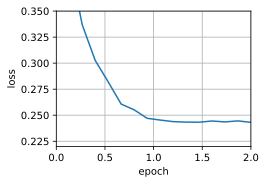

In [3]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim);

For a concise implementation we simply use the `adadelta` algorithm from the `Trainer` class. This yields the following one-liner for a much more compact invocation.


loss: 0.243, 0.017 sec/epoch


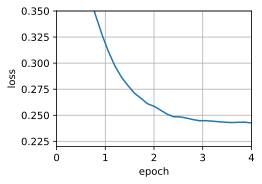

In [4]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## Summary

* Adadelta has no learning rate parameter. Instead, it uses the rate of change in the parameters itself to adapt the learning rate.
* Adadelta requires two state variables to store the second moments of gradient and the change in parameters.
* Adadelta uses leaky averages to keep a running estimate of the appropriate statistics.

## Exercises

1. Adjust the value of $\rho$. What happens?
1. Show how to implement the algorithm without the use of $\mathbf{g}_t'$. Why might this be a good idea?
1. Is Adadelta really learning rate free? Could you find optimization problems that break Adadelta?
1. Compare Adadelta to Adagrad and RMS prop to discuss their convergence behavior.


[Discussions](https://discuss.d2l.ai/t/1076)
